### 第4週、3日目 - その他のLangGraphへようこそ。

#### 概要
LangGraphで「ツールを使うエージェントグラフ」と「永続化された会話メモリ」を組み合わせた高度なチャットAIシステムの実装例  
特にLangGraph独自の「スーパーステップ」「チェックポイント」「状態管理」について重点的に解説し、実際に実装

- 1. LangGraphとLangChainの基礎
  - import
  - `.env`ファイルのロード

- 2. LangChainのツール実装
   - `GoogleSerperAPIWrapper`を使ったGoogle検索ツールの実装
   - LangChainの`Tool`クラスで関数をツール化し、`invoke`メソッドで利用
   - Pushover APIを使ったプッシュ通知送信ツールの自作例も掲載。

- 3. LangGraphによるエージェントグラフ構築
   - ユーザーとAIの会話（messages）を状態（State）として管理する設計。
   - LangChainのツールをOpenAIのモデルにバインドし、ツール呼び出しを自動化。
   - ノード追加、条件付きエッジ設定などグラフの組み立て。
   - グラフの状態可視化（Mermaid図）も実施。

- 4. メモリ（Memory）の追加
   - LangGraphの`MemorySaver`で会話履歴の保存。
   - チェックポイント（super-step）ごとに状態を保存・復元できる仕組みを解説。
   - チェックポイントIDを指定し、任意の時点から再開・分岐可能な設計を紹介。

- 5. SQLへの状態保存
   - SQLiteを用いた永続的な会話履歴（状態）の保存方法。
   - `SqliteSaver`でLangGraphのチェックポイントをDBに記録。

- 6. GradioによるチャットUI
   - 上記グラフを使ったチャットインターフェースをGradioで実装。

In [1]:
# import

# 基本
import os
import random
import requests
from dotenv import load_dotenv
from typing import Annotated
from typing import TypedDict
from pydantic import BaseModel

# langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode, tools_condition

# 表示
from IPython.display import Image, display
import gradio as gr

In [2]:
# 私たちのお気に入りの最初のステップ！（CrewAIは自動的に行っていた）
load_dotenv(override=True)


True

### まず、LangSmith をセットアップしましょう！

https://langsmith.com

- サインアップ、ログインした後に表示されるダッシュボードで、[Get Started] > [Set up tracing]を押下、
- pipでのパッケージのインストール方法（不要）と、設定すべき環境変数（必要）が示されるので、PJに反映

### LangChainコミュニティの有用な機能
Serper API（Google検索を利用したサーチAPI） をラップしたユーティリティ、LLMは使用していない。

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("What is the capital of France?") # フランスの首都は？

'Paris is the capital and largest city of France, with an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi). Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. The capital of France has been Paris since its liberation in 1944. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris is the capital city of France and a cultural and culinary hub. In 2024 it played host to its third Olympic Games. Paris, situated on the river 

### 機能の関数をLangChainツールに変換

In [4]:
from langchain.agents import Tool

tool_search =Tool(
    name="search",
    func=serper.run,
    # オンライン検索でさらに情報が必要な場合に便利です
    description="Useful for when you need more information from an online search"
)

### LangChainツールを試す

In [5]:
tool_search.invoke("What is the capital of France?") # # フランスの首都は？

'Paris is the capital and largest city of France, with an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi). Paris is the capital and most populous city of France. Situated on the Seine River, in the north of the country, it is in the centre of the Île-de-France ... Paris is the capital of France, the largest country of Europe with 550 000 km2 (65 millions inhabitants). Paris has 2.234 million inhabitants end 2011. The capital of France has been Paris since its liberation in 1944. Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and ... Paris is the city of romance par excellence, the fashion capital and the best example of French art de vivre. Exploring Paris is an essential rite of passage ... Paris, the capital of France, is often referred to as the "City of Light" and is renowned for its art, culture, and history. Capital city: Paris; Off

### そして今、自分でツールを書きましょう

おなじみのものを選びます

In [6]:
# プッシュ通知するツール

pushover_token = os.getenv("PUSHOVER_TOKEN")
pushover_user = os.getenv("PUSHOVER_USER")
pushover_url = "https://api.pushover.net/1/messages.json"

def push(text: str):
    """Send a push notification to the user""" # ユーザーにプッシュ通知を送信する
    requests.post(pushover_url, data = {"token": pushover_token, "user": pushover_user, "message": text})

tool_push = Tool(
    name="send_push_notification",
    func=push,
    # プッシュ通知を送信したいときに便利です
    description="useful for when you want to send a push notification"
)

tool_push.invoke("Hello, me")

### 昨日の Graph に戻る

- 1つの小さな変更 - StateクラスのBaseModelの代わりにTypedDictを使用する

- ツールを実装する際には、必ずコードに2つの変更を加える必要があります。
1. 呼び出し時にOpenAIにツールをJSON形式で提供するための変更
2. 結果の処理方法の変更：finish_reason=="tool_calls" の条件を満たすモデルを探し、呼び出しを取得して関数を実行し、結果を提供します。

### それらをまとめてください

In [7]:
tools = [tool_search, tool_push]

### ステップ1-5

In [8]:
# ステップ1：Stateクラスを定義
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [9]:
# ステップ2：Stateクラスでグラフビルダーを起動
graph_builder = StateGraph(State)

In [10]:
# ステップ3：Nodeを作成

# LLMにツールを設定
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [11]:
# ステップ4：グラフを作成
# NodeとEdgeを追加してGraphを作成

# Node
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Edge: START → chatbot
graph_builder.add_edge(START, "chatbot")

# Edge: chatbot ⇔ tools (双方向)
graph_builder.add_conditional_edges("chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")

# END は必須ではない、終応答を返した時点で遷移が無ければ処理は自然に終了。
# tools_conditionは「finish_reason=="tool_calls"」を判定しへ進むノードを判定するための条件分岐関数

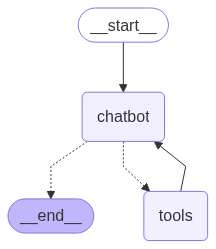

In [12]:
# ステップ5：グラフをコンパイルして可視化
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### それでおしまい！そして、これをしましょう：
２つのツールを使用する履歴機能付きChat

以下のように入力し、2つのツールが利用されることを確認する。

- hi there
- please send me a push notification with the current USD/GBP exchange rate

しかし、まだ、Stateは履歴を保持していないことを確認。

- hi there
- my name's Ed
- what's my name?

また、https://langsmith.com にアクセスしてトレースを確認するなど。

In [13]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


## さあ、メモリを追加しましょう！

### でもちょっと待ってください！

グラフ全体が State を維持し、State に追加していきます。なぜメモリを処理しないのでしょうか？

（結論を先にいうと、スーパーステップをまたいで（複数ターンにわたって）」状態を保持できないため）

### これはLangGraphを理解するための重要なポイントです

> スーパーステップは、グラフノードに対する単一の反復処理と考えることができます。
> 並列に実行されるノードは同じスーパーステップの一部ですが、順番に実行されるノードは別々のスーパーステップに属します。

グラフ上の1つの「スーパーステップ」は、エージェント間でメッセージを渡す1回の呼び出しを表します。

idomatic LangGraphでは、各スーパーステップ、つまり各インタラクションごとにinvokeを呼び出してグラフを実行します。

Reducerは、1つのスーパーステップ内では状態の更新を自動的に処理しますが、スーパーステップ間では処理しません。

これがチェックポイント機能によって実現されます。

In [14]:
# Memoryストア
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

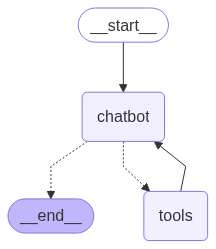

In [15]:
# ステップ1および2
graph_builder = StateGraph(State)

# ステップ3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# ステップ4
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")

# ステップ5
graph = graph_builder.compile(checkpointer=memory) # ★ memoryに変更
display(Image(graph.get_graph().draw_mermaid_png()))

### Stateが履歴を保持していることを確認
- hi there
- my name's Ed
- what's my name?

※ UIを再起動しても、Stateの履歴がメモリストアに残っていることを確認できる（メモリストアはカーネルを再起動すると消える）。

※ ただし、`{"thread_id": "2"}` に書き換えると、スロットが切り替わり記憶なしの状況から再開される。

In [16]:
# LangChain の RunnableConfigで、会話のセッション（スレッド）を区別するIDを作成
# StateGraphで、thread_id が違えば別の会話セッションとして履歴を分離できる
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


In [19]:
graph.get_state(config)

# 最初の状態（thread_id=1 における 0ステップ目の会話状態）
# StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '1'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())

# 最後の状態（thread_id=1 における 7ステップ目の会話状態）
# StateSnapshot(
#   values={'messages': [ # 対話ログが格納されている。
#     HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='cd019904-1e60-4b9e-8303-c4cb08d7b42c'),
#     AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 90, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CChUFLidR0nZajyb8hDYsOPiooEZM', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--790b77d1-af86-4247-b571-1deeb259cf99-0', usage_metadata={'input_tokens': 90, 'output_tokens': 10, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
#     HumanMessage(content="my name's Ed", additional_kwargs={}, response_metadata={}, id='0b83eda2-f50a-4ddf-9e03-1087d3fa9dd2'),
#     AIMessage(content='Nice to meet you, Ed! What can I help you with today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 111, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CChUItcBdT8KLzPDEKMH2U4uCbrgV', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--99c79875-2918-453a-b3f6-d10f241336ff-0', usage_metadata={'input_tokens': 111, 'output_tokens': 16, 'total_tokens': 127, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
#     HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='c25367ed-d309-4fcb-be67-65cad2b69ca1'),
#     AIMessage(content='Your name is Ed.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 139, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CChUKb4hNh9JLFOiWGMSRSaucvCAU', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--87b1a333-328c-4bb9-9b4b-110bb3357a0b-0', usage_metadata={'input_tokens': 139, 'output_tokens': 6, 'total_tokens': 145, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]},
#   next=(), # 次に実行すべきノードが空 → 現時点ではワークフローが終了状態。
#   config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08af1c-2da7-6956-8007-bff50d3f8158'}},
#   metadata={'source': 'loop', 'writes': {'chatbot': {'messages': [AIMessage(content='Your name is Ed.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 139, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CChUKb4hNh9JLFOiWGMSRSaucvCAU', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--87b1a333-328c-4bb9-9b4b-110bb3357a0b-0', usage_metadata={'input_tokens': 139, 'output_tokens': 6, 'total_tokens': 145, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}, 'step': 7, 'parents': {}, 'thread_id': '1'}, created_at='2025-09-06T07:19:00.933414+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08af1c-274c-6952-8006-2d626f43a25f'}},
#   tasks=(), interrupts=()) # このステップで保留中のタスクや割り込みはなし。

StateSnapshot(values={'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='598e712d-4270-40c5-bf76-077efb08ceea'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 90, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CChlgZWMisYuAUV2PmCRxP39k04fA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8a6d1d9c-bed5-4bff-9e8a-882a40cae025-0', usage_metadata={'input_tokens': 90, 'output_tokens': 10, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMe

In [20]:
# State履歴は、StateSnapshotのスタック
list(graph.get_state_history(config))

# 最初の状態
# []

# 最後の状態
# StateSnapshot( ...step': 7...
#  StateSnapshot( ...step': 6...
#  StateSnapshot( ...step': 5...
#  StateSnapshot( ...step': 4...
#  StateSnapshot( ...step': 3...
#  StateSnapshot( ...step': 2...
#  StateSnapshot( ...step': 1...
#  StateSnapshot( ...step': 0...
#  StateSnapshot( ...step': -1...

[StateSnapshot(values={'messages': [HumanMessage(content='hi there', additional_kwargs={}, response_metadata={}, id='598e712d-4270-40c5-bf76-077efb08ceea'), AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 90, 'total_tokens': 100, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CChlgZWMisYuAUV2PmCRxP39k04fA', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8a6d1d9c-bed5-4bff-9e8a-882a40cae025-0', usage_metadata={'input_tokens': 90, 'output_tokens': 10, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanM

### LangGraphは、Stateを以前の時点に戻し、分岐するためのツールを提供

```python
# thread_idのcheckpoint_idを指定することで、以前の時点に戻れる。
config = {"configurable": {"thread_id": "1", "checkpoint_id": ...}}
graph.invoke(None, config=config)
```

また、これにより、回復できる安定したシステムを構築し、以前のチェックポイントから再実行できます。

### 次に、SQLに保存しましょう

### これがLangChainの力です。

In [21]:
# DBストア
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

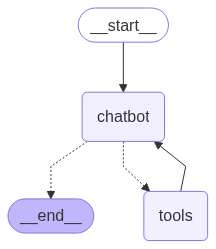

In [22]:
# ステップ1および2
graph_builder = StateGraph(State)

# ステップ3
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# ステップ4
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

graph_builder.add_edge(START, "chatbot")
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")

# ステップ5
graph = graph_builder.compile(checkpointer=sql_memory) # ★ sql_memoryに変更
display(Image(graph.get_graph().draw_mermaid_png()))

### Stateが履歴を保持していることを確認
- hi there
- my name's Ed
- what's my name?
 
※ UI、カーネルを再起動しても、Stateの履歴がDBストアに残っていることを確認できる。

※ ただし、`{"thread_id": "4"}` に書き換えると、スロットが切り替わり記憶なしの状況から再開される。

In [ ]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content

gr.ChatInterface(chat, type="messages").launch()